# 1. INTRODUCTION

AutoML simplifies the tasks of 1) choosing the best machine learning model and 2) hyperparameter tuning by autonomously determining the most suitable model algorithm for inference. This notebook compares the effectiveness of three different AutoML packages on the Heart Failure Prediction dataset.

## 1.1. Steps

* Preprocessing A: check for null values and outliers
* Preprocessing B: standardise numerical variable distributions and Encode categorical variables (OneHotEncoder)
* Run Autogluon, FLAML and AutoSKLearn autoML models 
* Measure each model's performance metrics (Accuracy, Precision, F1, Recall, ROC AUC and Confusion Matrix)

## 1.2. Summary of findings

The results indicate that <b>Autogluon</b> outperforms the other two packages, while <b>AutoSKLearn</b> performs the worst. One of the reasons for this difference in performance could be the availability of model algorithms. <b>AutoSKLearn</b> only uses models available in SKLearn and forms ensembles from base learners such as regression, decision tree, and kNN. In contrast, <b>FLAML</b> and <b>Autogluon</b> AutoML include advanced model algorithms like XGBoost, LGBM, and CatBoost. Despite the advanced model algorithms, <b>Autogluon</b> AutoML also uses an ensemble classifier based on the base advanced model learners of XGBoost and LGBM. This drives <b>Autogluon</b> to slightly outperform <b>FLAML</b>, as <b>FLAML</b> has no ensemble classifier from the base learners.

# 2. SETUP

Install necessary packages/modules first.

## 2.1. Modules

In [21]:
# Data Processing - General
import numpy as np 
import pandas as pd 
import os

# Data Standardisation and Encoding
from sklearn.preprocessing import RobustScaler, OneHotEncoder

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Model Performance Metrics
from sklearn import model_selection, metrics, naive_bayes

# Plotting and Visualisation
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


## 2.2. Load Dataset

This dataset was provided by fedesoriano and it is available in the Kaggle platform: [Heart Failure Prediction Dataset](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction)

In [22]:
df_heart = pd.read_csv('/workspaces/AI.ML_ICL.projects/Project_1/data/heart.csv')
print('# Rows: {}, # Columns: {}'.format(df_heart.shape[0], df_heart.shape[1]))

# Rows: 918, # Columns: 12


### 2.2.1. Quick overview of the dataset

In [23]:
print(df_heart.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
None


In [24]:
print(df_heart.describe(include=['object', 'category']))

        Sex ChestPainType RestingECG ExerciseAngina ST_Slope
count   918           918        918            918      918
unique    2             4          3              2        3
top       M           ASY     Normal              N     Flat
freq    725           496        552            547      460


In [25]:
for column in df_heart.columns:
    print(f"Unique values in {column}:")
    print(df_heart[column].unique()) 

Unique values in Age:
[40 49 37 48 54 39 45 58 42 38 43 60 36 44 53 52 51 56 41 32 65 35 59 50
 47 31 46 57 55 63 66 34 33 61 29 62 28 30 74 68 72 64 69 67 73 70 77 75
 76 71]
Unique values in Sex:
['M' 'F']
Unique values in ChestPainType:
['ATA' 'NAP' 'ASY' 'TA']
Unique values in RestingBP:
[140 160 130 138 150 120 110 136 115 100 124 113 125 145 112 132 118 170
 142 190 135 180 108 155 128 106  92 200 122  98 105 133  95  80 137 185
 165 126 152 116   0 144 154 134 104 139 131 141 178 146 158 123 102  96
 143 172 156 114 127 101 174  94 148 117 192 129 164]
Unique values in Cholesterol:
[289 180 283 214 195 339 237 208 207 284 211 164 204 234 273 196 201 248
 267 223 184 288 215 209 260 468 188 518 167 224 172 186 254 306 250 177
 227 230 294 264 259 175 318 216 340 233 205 245 194 270 213 365 342 253
 277 202 297 225 246 412 265 182 218 268 163 529 100 206 238 139 263 291
 229 307 210 329 147  85 269 275 179 392 466 129 241 255 276 282 338 160
 156 272 240 393 161 228 292 388 166 24

### 2.2.1. Metadata

The dataset consists of 918 records, each containing information regarding the following variables: 

* Age: age of the patient [years]</div>
* Sex: sex of the patient [M: Male, F: Female]</div>
* ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]</div>
* RestingBP: resting blood pressure [mm Hg]</div>
* Cholesterol: serum cholesterol [mm/dl]</div>
* FastingBS: fasting blood sugar [1 if FastingBS > 120 mg/dl, 0 otherwise]</div>
* RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]</div>
* MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]</div>
* ExerciseAngina: exercise-induced angina [Y: Yes, N: No]</div>
* Oldpeak: oldpeak = ST [Numeric value measured in depression]</div>
* ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]</div>
* HeartDisease: target class [1: heart disease, 0: Normal]</div>


Input Variables - Age, Sex, ChestPainType, RestingBP, Cholesterol, FastingBS, RestingECG, MaxHR, ExerciseAngina, Oldpeak, ST_Slope

Output Variable/Label - HeartDisease

# 3. EDA

## 3.1. Check whether the dataset is balanced

To check if the dataset is balanced we'll have a quick look at the distribution of the labels:

In [26]:
# Count label=0 and label=1, get their ratios
label_0=df_heart['HeartDisease'].value_counts()[0]
label_1=df_heart['HeartDisease'].value_counts()[1]
total_count = df_heart['HeartDisease'].value_counts().sum()
label0_ratio = label_0 / total_count

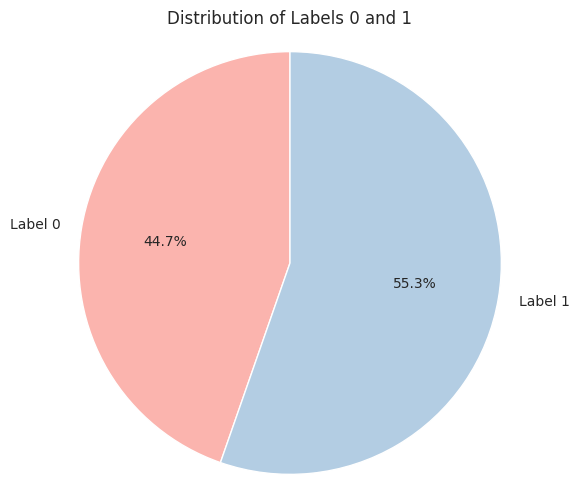

In [27]:
# Define colormap
cmap = plt.get_cmap('Pastel1')

# Calculate percentages
label_0_pct = label_0 / total_count
label_1_pct = label_1 / total_count

# Plotting data
labels = ['Label 0', 'Label 1']
sizes = [label_0_pct, label_1_pct]
colors = [cmap(0), cmap(1)] 

# Create a pie chart for easy visualization
plt.figure(figsize=(6, 6)) 
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.axis('equal')  
plt.title('Distribution of Labels 0 and 1') 
plt.show()  

The output variable seems to be distributed quite evenly (i.e. the number of positive and negative HD diagnostics is fairly similar). No need for oversampling.

## 3.2. Check for missing values

If the data has missing values (i.e. blank or N/A values), these need to be replaced accordingly (e.g. by replacing them with the mean -simmetrically distributed data - or median - skewed data - in case of numerical variables and with the mode in case of categorical variables).

In [28]:
df_heart.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

There are no missing values in the dataset, so we can proceed.

## 3.2. Group metadata into categorical/numerical features

Here we'll try to spot abnormal observations in the dataset, as these tend to skew data distributions and lead to inaccurate model performance later on.

In [29]:
# identify the type of features into either numerical or categorical by values of the features

cat = df_heart.select_dtypes(include=['object', 'category']).columns.tolist()
num = df_heart.select_dtypes(include=[np.number]).columns.tolist()

print("Categorical Variables:", list(cat))
print("Numerical Variables:", list(num))

Categorical Variables: ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
Numerical Variables: ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'HeartDisease']


Although 'FastingBS' is in theory a numerical variable (i.e. it takes the values 0 and 1), we can define it as a categorical one, since these numbers represent a Yes (1) and No (0). 

In [30]:
# Remove FastingBS from num list and add it to cat list
if 'FastingBS' in num:
    num.remove('FastingBS')  
    cat.append('FastingBS')  

print("Updated Categorical Variables:", cat)
print("Updated Numerical Variables:", num)

Updated Categorical Variables: ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'FastingBS']
Updated Numerical Variables: ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'HeartDisease']


Summarising the dataset features now:

In [31]:
print ('Dataset dimensions: {}'.format(df_heart.shape))
print ('Number of features: {}'.format (len(cat) + len(num)))
print ('Number of categorical features: {}'.format (len(cat)))
print ('Number of numerical features: {}'.format (len(num)))

Dataset dimensions: (918, 12)
Number of features: 12
Number of categorical features: 6
Number of numerical features: 6


## 3.3. Check for outliers

In [32]:
df_heart[num].describe()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,202.000000,6.200000,1.000000


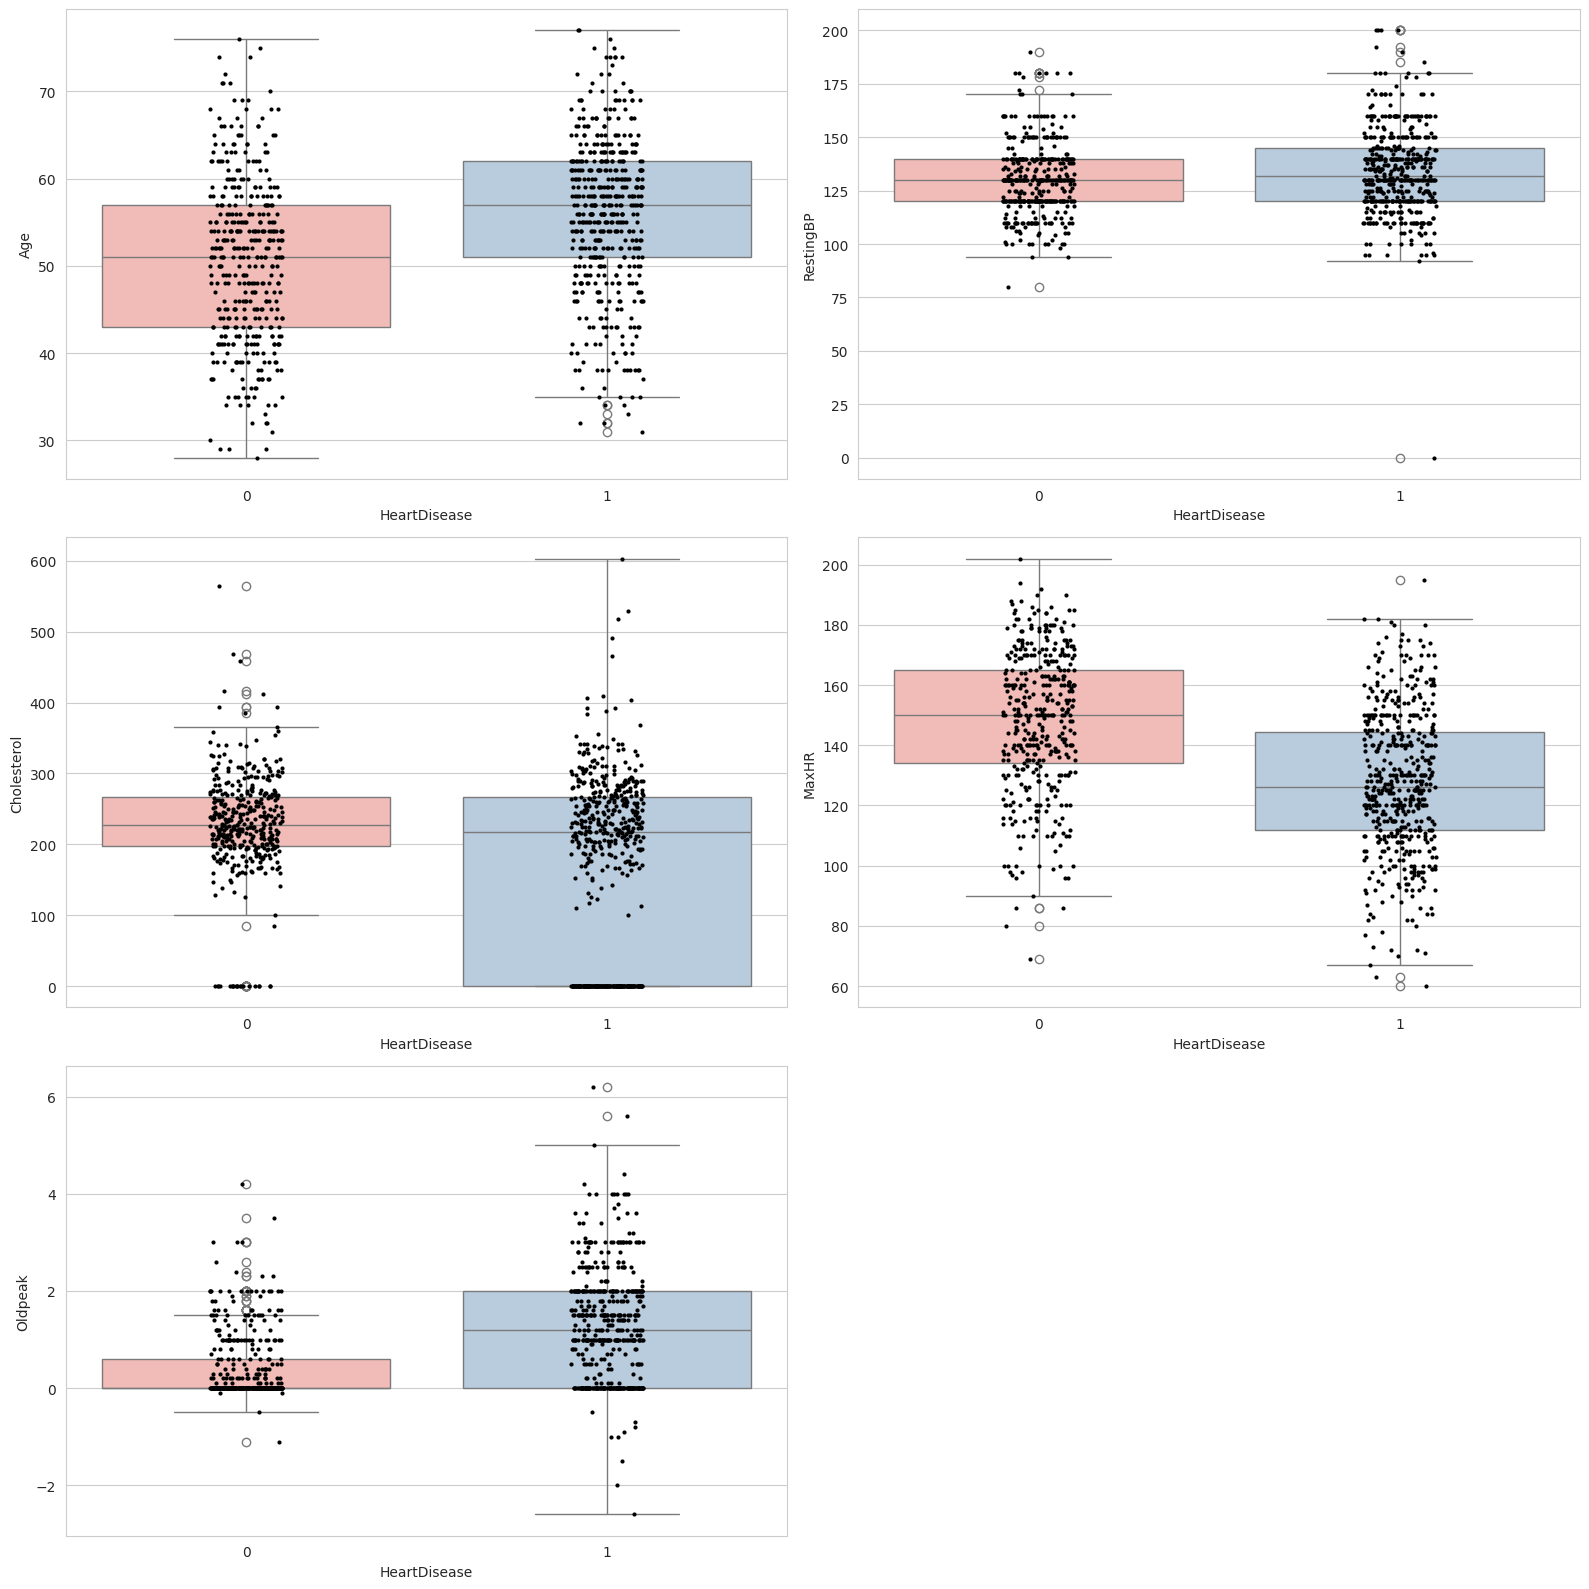

In [33]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    sns.set_style("whitegrid")

    fig, ax = plt.subplots(3, 2, figsize=(16, 16))


    palette = plt.get_cmap('Pastel1')
    colors = [palette(i) for i in range(2)]  

    sns.boxplot(x="HeartDisease", y="Age", data=df_heart, ax=ax[0][0], palette=colors)
    sns.stripplot(x="HeartDisease", y="Age", data=df_heart, ax=ax[0][0], color='black', size=3, jitter=True)

    sns.boxplot(x="HeartDisease", y="RestingBP", data=df_heart, ax=ax[0][1], palette=colors)
    sns.stripplot(x="HeartDisease", y="RestingBP", data=df_heart, ax=ax[0][1], color='black', size=3, jitter=True)

    sns.boxplot(x="HeartDisease", y="Cholesterol", data=df_heart, ax=ax[1][0], palette=colors)
    sns.stripplot(x="HeartDisease", y="Cholesterol", data=df_heart, ax=ax[1][0], color='black', size=3, jitter=True)

    sns.boxplot(x="HeartDisease", y="MaxHR", data=df_heart, ax=ax[1][1], palette=colors)
    sns.stripplot(x="HeartDisease", y="MaxHR", data=df_heart, ax=ax[1][1], color='black', size=3, jitter=True)

    sns.boxplot(x="HeartDisease", y="Oldpeak", data=df_heart, ax=ax[2][0], palette=colors)
    sns.stripplot(x="HeartDisease", y="Oldpeak", data=df_heart, ax=ax[2][0], color='black', size=3, jitter=True)

    fig.delaxes(ax[2][1])

    plt.tight_layout()

    plt.show()


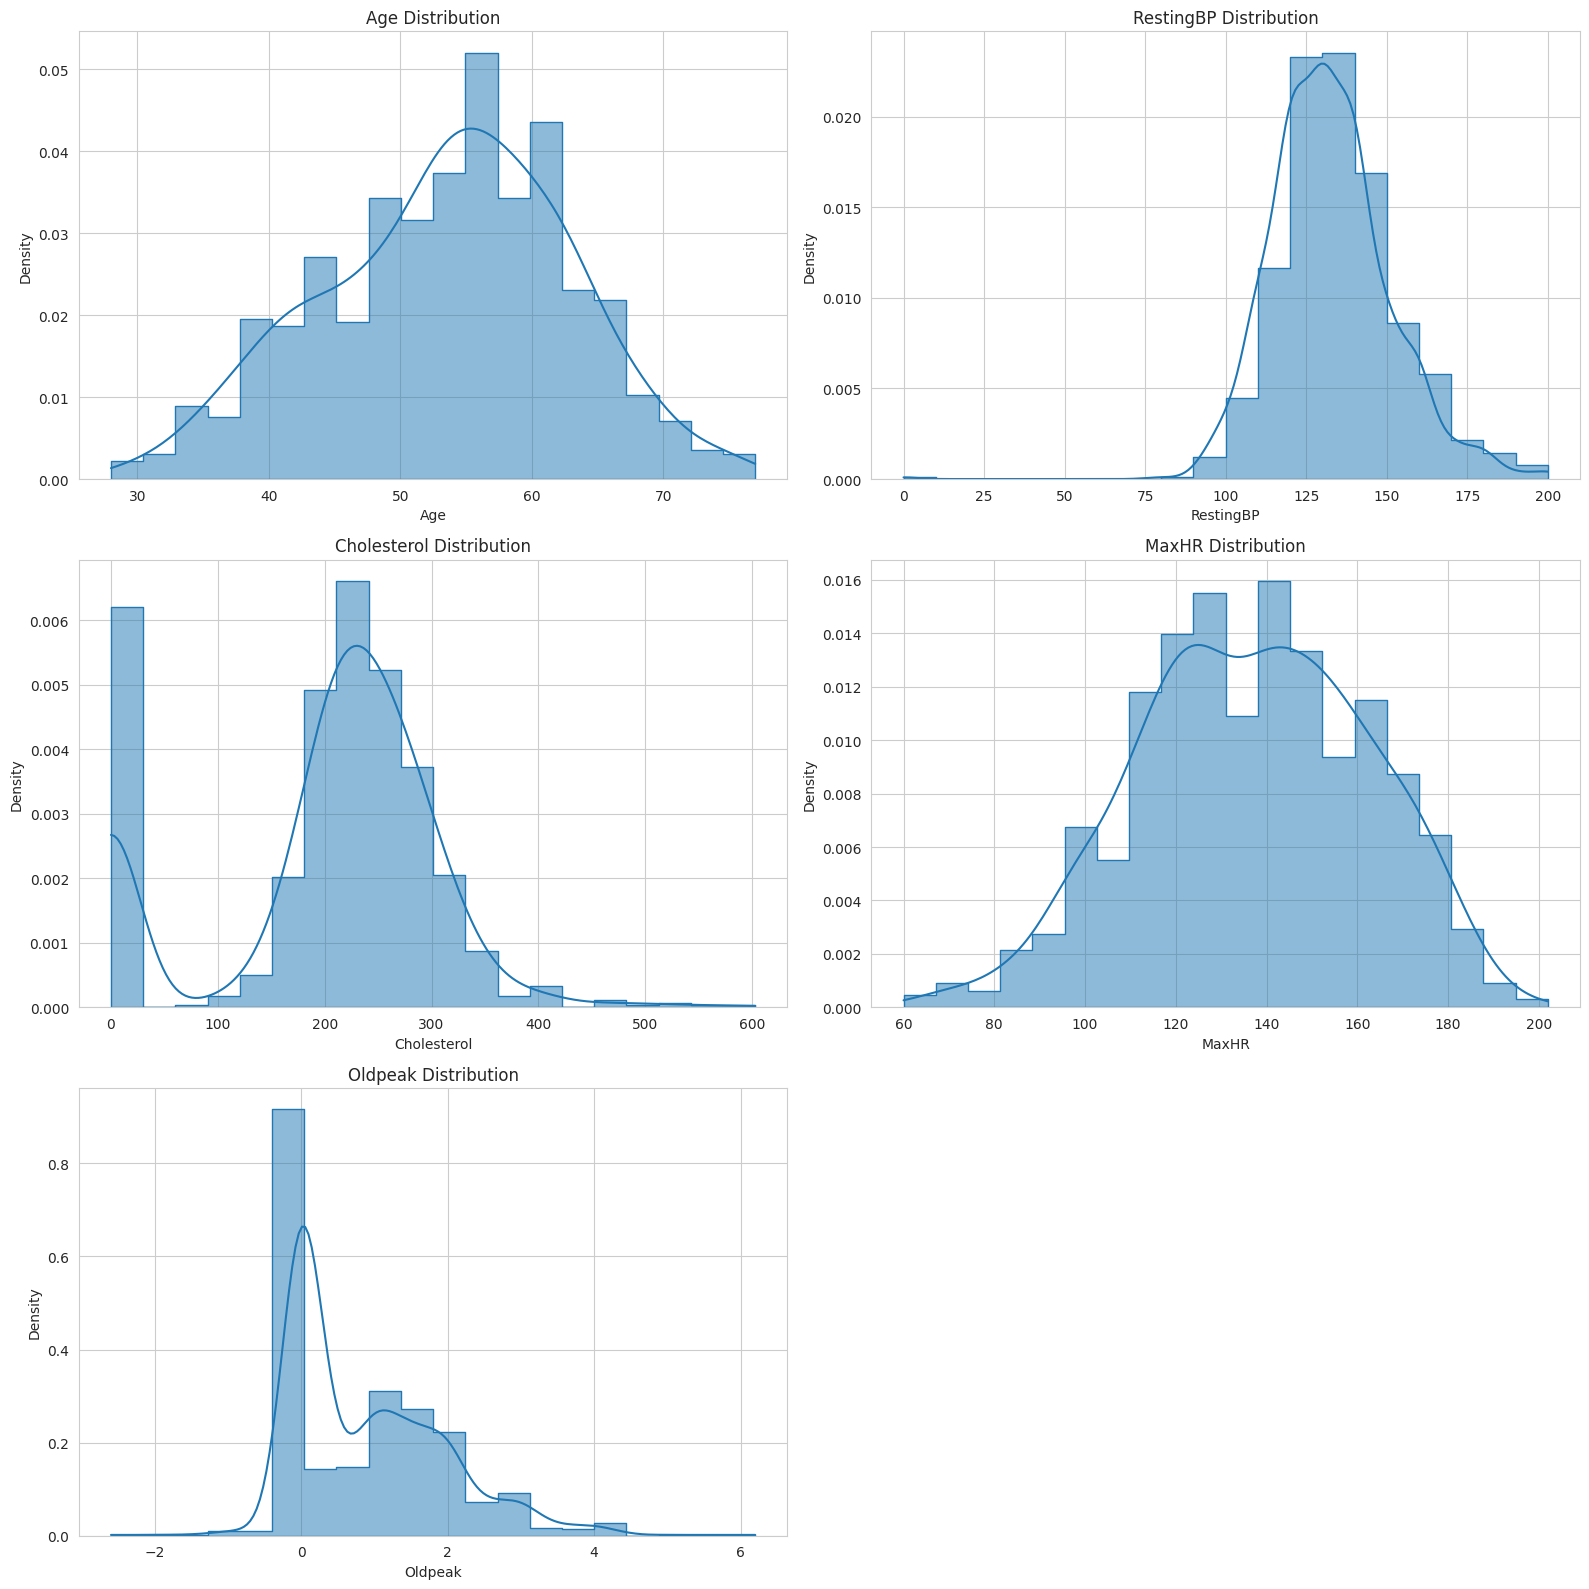

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Ignore warnings in this block
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # Create a larger figure to handle additional subplots
    fig, ax = plt.subplots(3, 2, figsize=(16, 16))

    # Histogram for 'Age'
    sns.histplot(data=df_heart, x="Age", kde=True, ax=ax[0][0], palette="pastel", bins=20, element="step", stat="density")
    ax[0][0].set_title("Age Distribution")

    # Histogram for 'RestingBP'
    sns.histplot(data=df_heart, x="RestingBP", kde=True, ax=ax[0][1], palette="pastel", bins=20, element="step", stat="density")
    ax[0][1].set_title("RestingBP Distribution")

    # Histogram for 'Cholesterol'
    sns.histplot(data=df_heart, x="Cholesterol", kde=True, ax=ax[1][0], palette="pastel", bins=20, element="step", stat="density")
    ax[1][0].set_title("Cholesterol Distribution")

    # Histogram for 'MaxHR'
    sns.histplot(data=df_heart, x="MaxHR", kde=True, ax=ax[1][1], palette="pastel", bins=20, element="step", stat="density")
    ax[1][1].set_title("MaxHR Distribution")

    # Histogram for 'Oldpeak'
    sns.histplot(data=df_heart, x="Oldpeak", kde=True, ax=ax[2][0], palette="pastel", bins=20, element="step", stat="density")
    ax[2][0].set_title("Oldpeak Distribution")

    # Remove the empty subplot for a cleaner look
    fig.delaxes(ax[2][1])

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    plt.show()


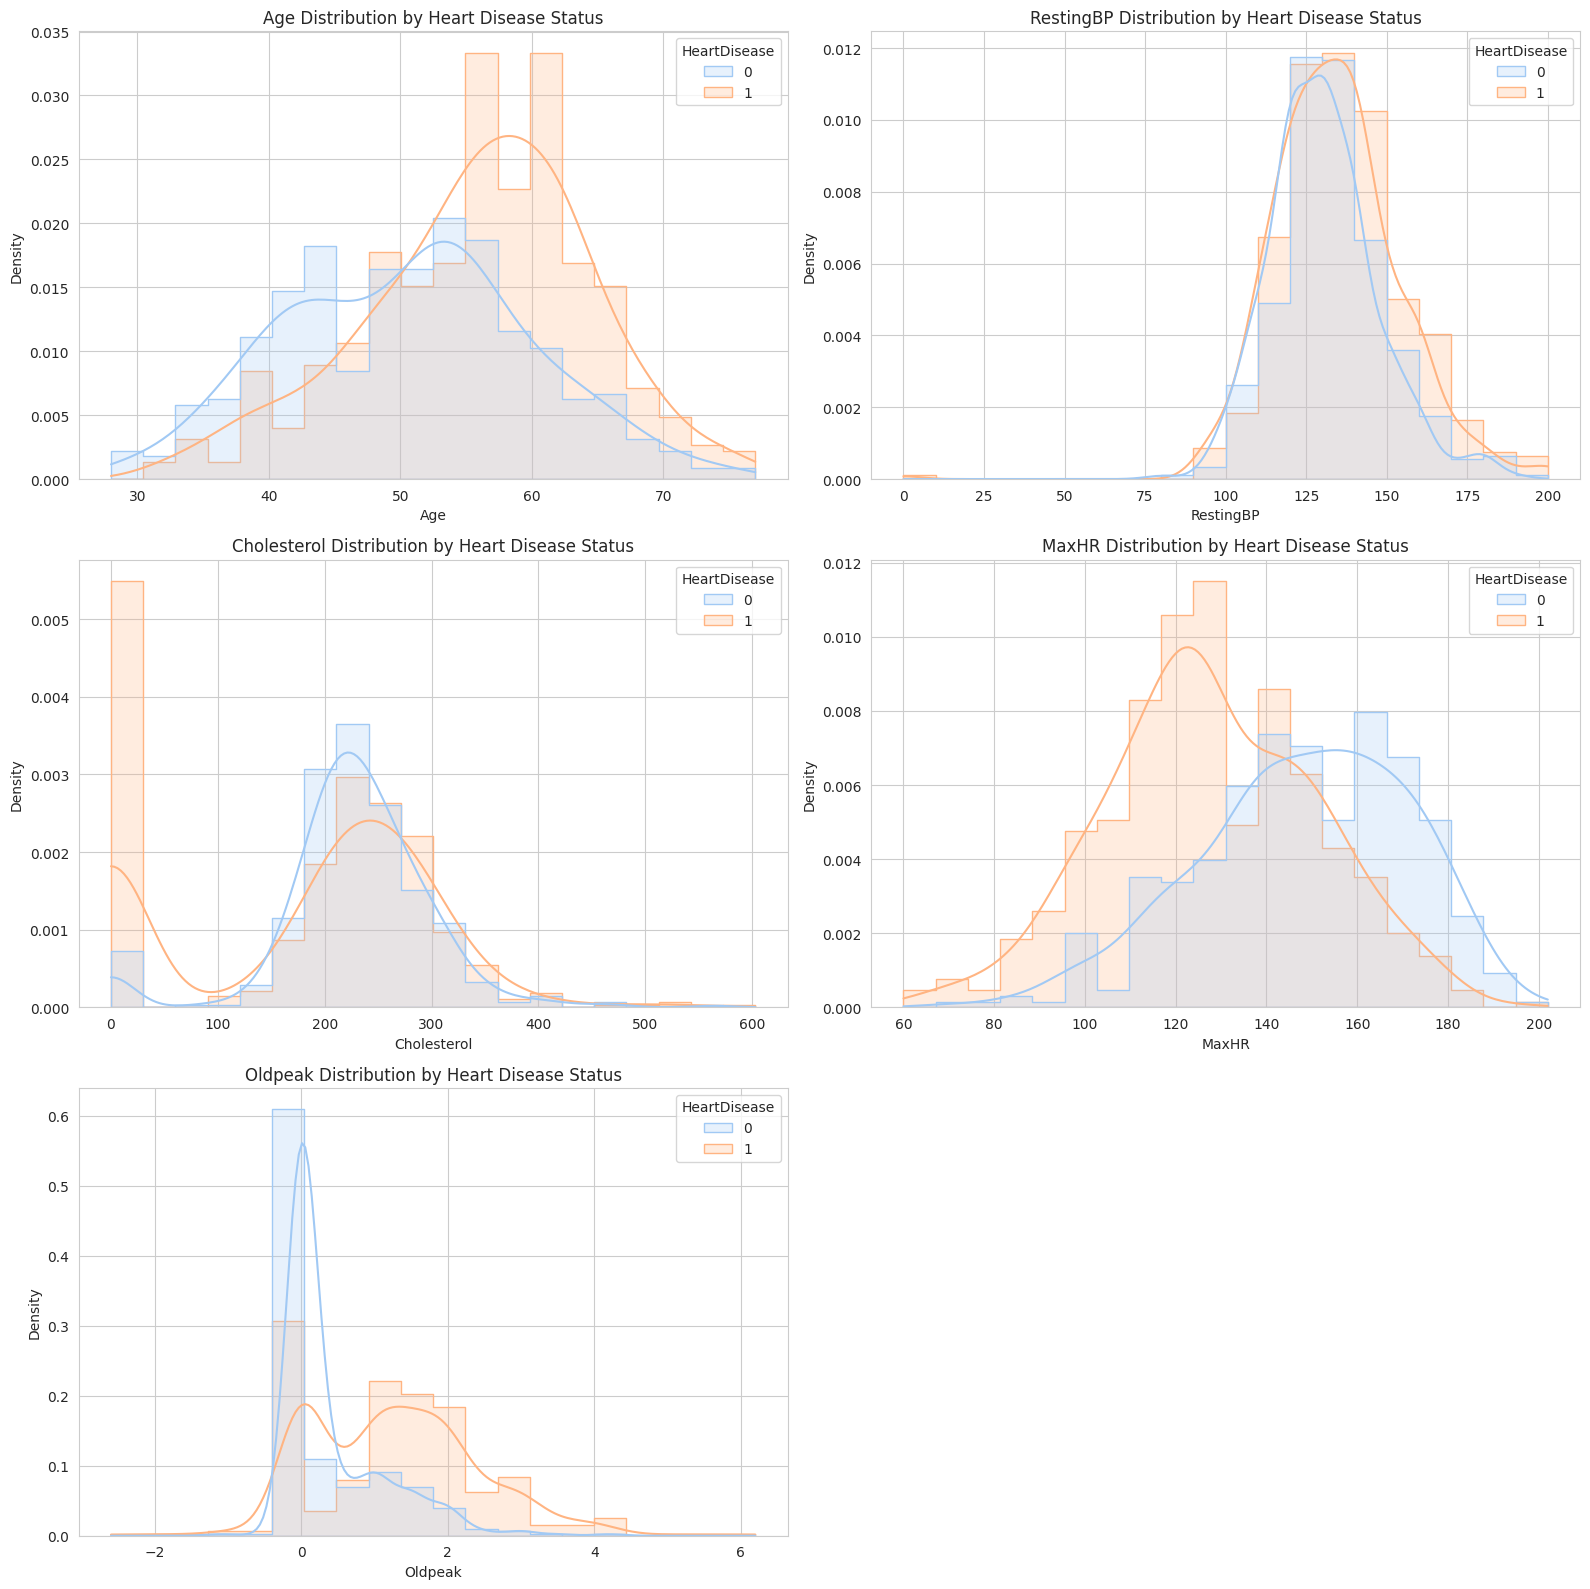

In [35]:
sns.set_style("whitegrid")

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    fig, ax = plt.subplots(3, 2, figsize=(16, 16))

    sns.histplot(data=df_heart, x="Age", hue="HeartDisease", kde=True, ax=ax[0][0], palette="pastel", bins=20, element="step", stat="density")
    ax[0][0].set_title("Age Distribution by Heart Disease Status")

    sns.histplot(data=df_heart, x="RestingBP", hue="HeartDisease", kde=True, ax=ax[0][1], palette="pastel", bins=20, element="step", stat="density")
    ax[0][1].set_title("RestingBP Distribution by Heart Disease Status")

    sns.histplot(data=df_heart, x="Cholesterol", hue="HeartDisease", kde=True, ax=ax[1][0], palette="pastel", bins=20, element="step", stat="density")
    ax[1][0].set_title("Cholesterol Distribution by Heart Disease Status")

    sns.histplot(data=df_heart, x="MaxHR", hue="HeartDisease", kde=True, ax=ax[1][1], palette="pastel", bins=20, element="step", stat="density")
    ax[1][1].set_title("MaxHR Distribution by Heart Disease Status")

    sns.histplot(data=df_heart, x="Oldpeak", hue="HeartDisease", kde=True, ax=ax[2][0], palette="pastel", bins=20, element="step", stat="density")
    ax[2][0].set_title("Oldpeak Distribution by Heart Disease Status")

    fig.delaxes(ax[2][1])

    plt.tight_layout()

    plt.show()


Looking at the plots and the data on the table above, it looks like some variables (e.g. cholesterol and rest BP) have some abnormal values. To remove/replace outliers, we'll follow the Interquartile Range (IQR) method and set up a threshold below 5% and above 95%: 

In [36]:
import numpy as np

for i in num:
    if i != 'HeartDisease':
        # Calculate the 95th and 5th percentiles for values greater than 0
        pc95 = df_heart[df_heart[i] > 0][i].quantile(0.95)
        pc5 = df_heart[df_heart[i] > 0][i].quantile(0.05)

        iqr = pc95 - pc5

        # Count outliers
        outlier_count_upper = df_heart[df_heart[i] > pc95][i].count()
        outlier_count_lower = df_heart[df_heart[i] < pc5][i].count()

        print(f'- {i}: Upper Limit (PC95%): {pc95:6.1f} || Bottom Limit (PC5%): {pc5:6.1f} || Outliers Above: {outlier_count_upper} || Outliers Below: {outlier_count_lower}')

- Age: Upper Limit (PC95%):   68.0 || Bottom Limit (PC5%):   37.0 || Outliers Above: 44 || Outliers Below: 38
- RestingBP: Upper Limit (PC95%):  160.0 || Bottom Limit (PC5%):  107.6 || Outliers Above: 43 || Outliers Below: 47
- Cholesterol: Upper Limit (PC95%):  339.8 || Bottom Limit (PC5%):  165.2 || Outliers Above: 38 || Outliers Below: 210
- MaxHR: Upper Limit (PC95%):  178.0 || Bottom Limit (PC5%):   96.0 || Outliers Above: 43 || Outliers Below: 45
- Oldpeak: Upper Limit (PC95%):    3.1 || Bottom Limit (PC5%):    0.2 || Outliers Above: 27 || Outliers Below: 395


We'll be checking abnormal values now, starting with 'Oldpeak', which is supposed to be a non-negative measure. Knowing the lowest value must be zero, we'll check the negative records:

In [37]:
# Cap values at the 95th percentile and floor values at the 5th percentile
df_heart['Oldpeak'] = np.where(df_heart['Oldpeak'] > pc95, pc95, df_heart['Oldpeak'])
df_heart['Oldpeak'] = np.where(df_heart['Oldpeak'] < pc5, pc5, df_heart['Oldpeak'])

df_heart['RestingBP'] = np.where(df_heart['RestingBP'] > pc95, pc95, df_heart['RestingBP'])
df_heart['RestingBP'] = np.where(df_heart['RestingBP'] < pc5, pc5, df_heart['RestingBP'])

df_heart['Cholesterol'] = np.where(df_heart['Cholesterol'] > pc95, pc95, df_heart['Cholesterol'])
df_heart['Cholesterol'] = np.where(df_heart['Cholesterol'] < pc5, pc5, df_heart['Cholesterol'])

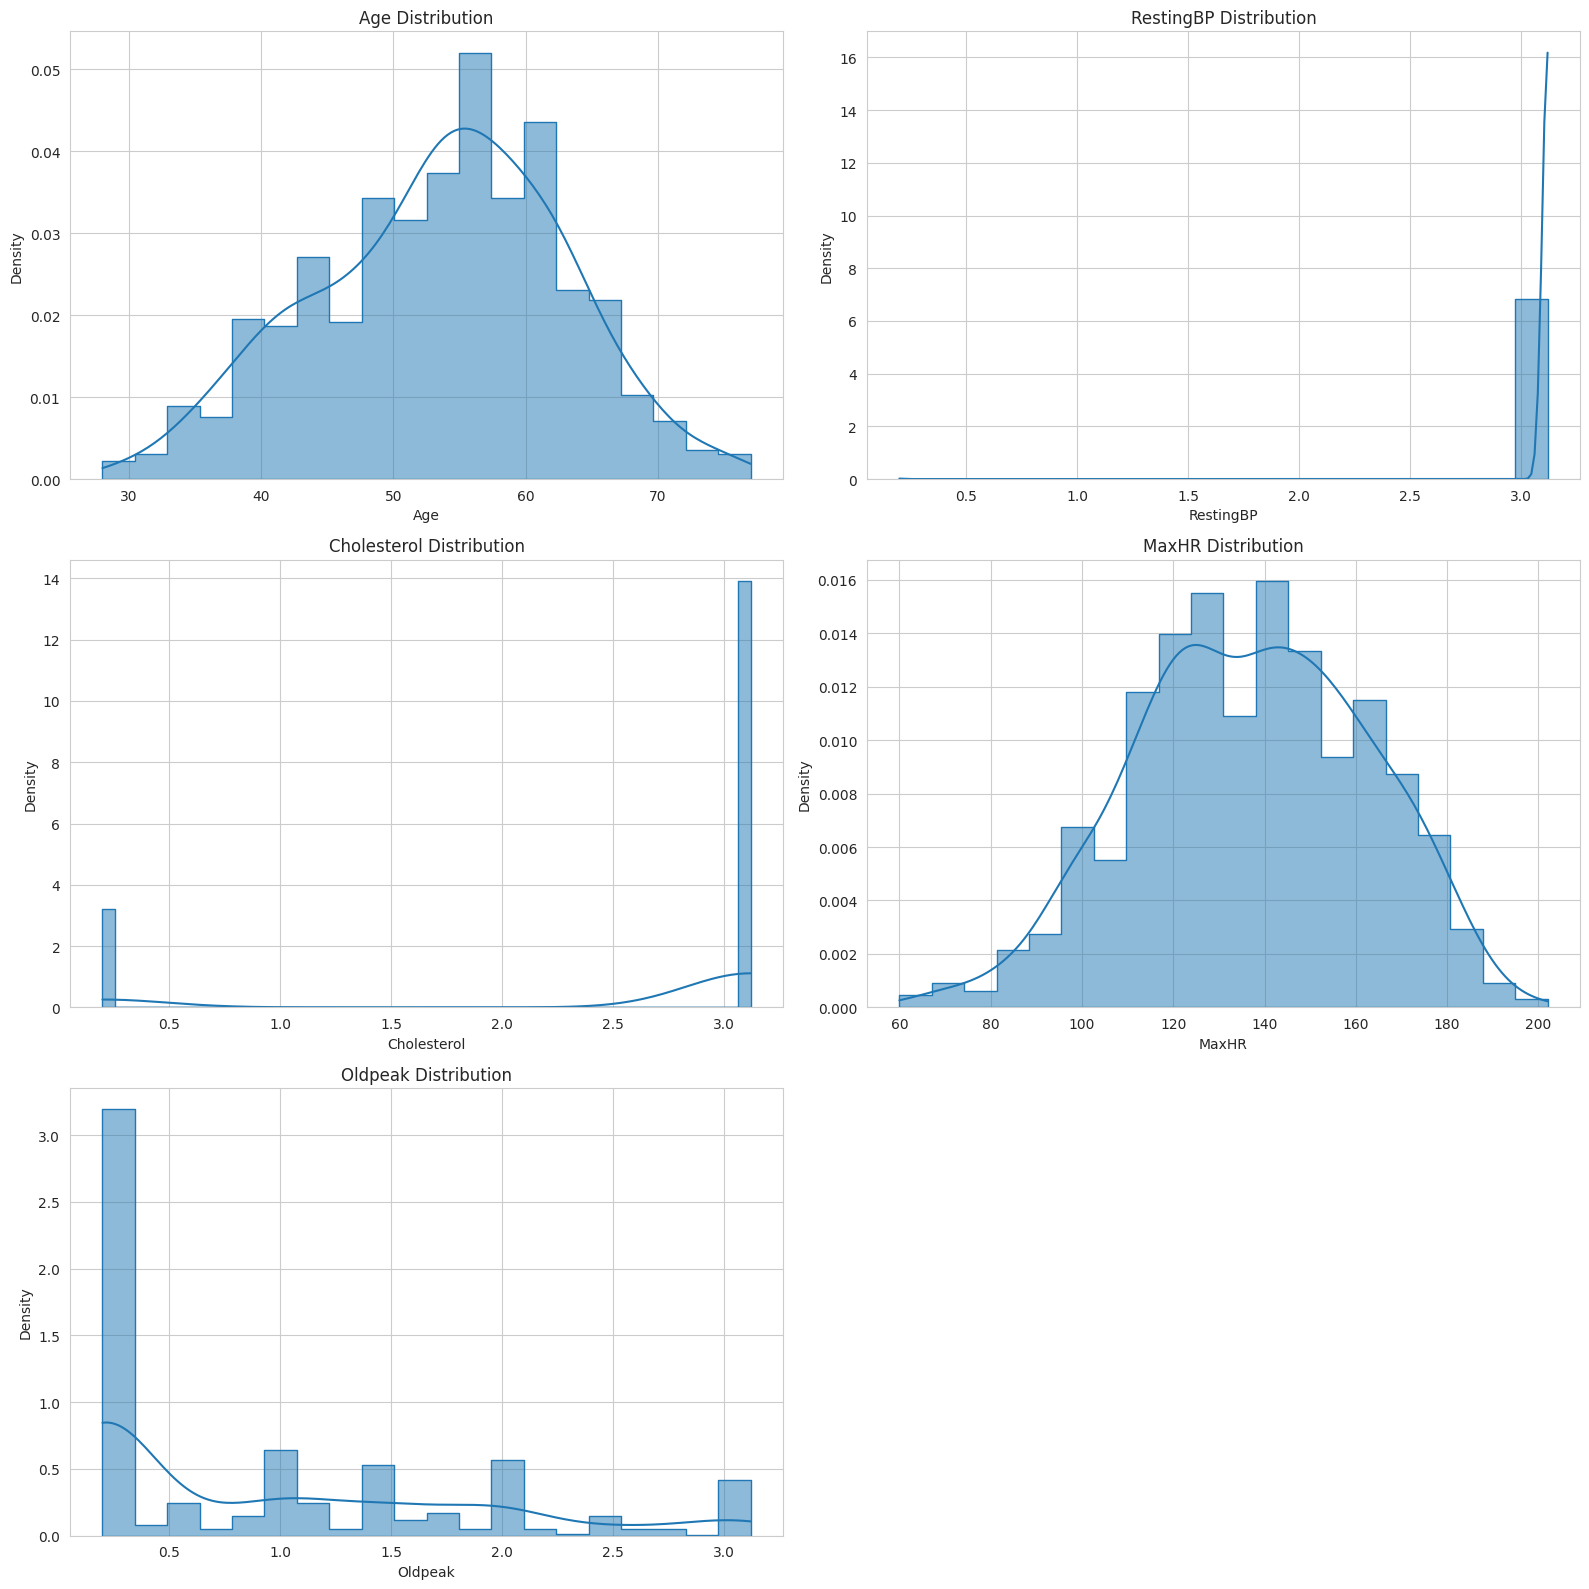

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Ignore warnings in this block
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # Create a larger figure to handle additional subplots
    fig, ax = plt.subplots(3, 2, figsize=(16, 16))

    # Histogram for 'Age'
    sns.histplot(data=df_heart, x="Age", kde=True, ax=ax[0][0], palette="pastel", bins=20, element="step", stat="density")
    ax[0][0].set_title("Age Distribution")

    # Histogram for 'RestingBP'
    sns.histplot(data=df_heart, x="RestingBP", kde=True, ax=ax[0][1], palette="pastel", bins=20, element="step", stat="density")
    ax[0][1].set_title("RestingBP Distribution")

    # Histogram for 'Cholesterol'
    sns.histplot(data=df_heart, x="Cholesterol", kde=True, ax=ax[1][0], palette="pastel", bins=50, element="step", stat="density")
    ax[1][0].set_title("Cholesterol Distribution")

    # Histogram for 'MaxHR'
    sns.histplot(data=df_heart, x="MaxHR", kde=True, ax=ax[1][1], palette="pastel", bins=20, element="step", stat="density")
    ax[1][1].set_title("MaxHR Distribution")

    # Histogram for 'Oldpeak'
    sns.histplot(data=df_heart, x="Oldpeak", kde=True, ax=ax[2][0], palette="pastel", bins=20, element="step", stat="density")
    ax[2][0].set_title("Oldpeak Distribution")

    # Remove the empty subplot for a cleaner look
    fig.delaxes(ax[2][1])

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    plt.show()


In [39]:
#df_heart['Oldpeak'] = np.where(df_heart['Oldpeak'] < 0, 0, df_heart['Oldpeak'])

In [40]:
#median_Cholesterol = df_heart['Cholesterol'].median()
#median_RestingBP = df_heart['RestingBP'].median()

# For Old Peak, we replace abnormal values with the 0.
# median_Oldpeak = df_heart['Oldpeak'].median()

#df_heart['Cholesterol'] = np.where(df_heart['Cholesterol'] <= 70, median_Cholesterol, df_heart['Cholesterol'])
#df_heart['RestingBP'] = np.where(df_heart['RestingBP'] <= 50, median_RestingBP, df_heart['RestingBP'])
#df_heart['Oldpeak'] = np.where(df_heart['Oldpeak'] < 0, 0, df_heart['Oldpeak'])